In [1]:
import datetime
from IPython import display
import pandas as pd
pd.options.display.max_columns = None
import advertools as adv
import plotly.express as px
from jupyter_dash import JupyterDash
from dash import dcc, html, Input, Output
from plotly.subplots import make_subplots
from dash_bootstrap_templates import load_figure_template

In [2]:
tweets = pd.read_csv('data/bitcoin_tweets.csv')
topic = 'bitcoin'
display.display_markdown("# Dataset overview (first five rows):", raw=True)
display.display_html("<br><br>", raw=True)

tweets.head()

# Dataset overview (first five rows):

,tweet_created_at,tweet_id,tweet_id_str,tweet_full_text,tweet_entities_mentions,tweet_entities_hashtags,tweet_entities_urls,tweet_entities_symbols,tweet_entities_media,tweet_source,tweet_in_reply_to_status_id,tweet_in_reply_to_status_id_str,tweet_in_reply_to_user_id,tweet_in_reply_to_user_id_str,tweet_in_reply_to_screen_name,tweet_is_quote_status,tweet_retweet_count,tweet_favorite_count,tweet_favorited,tweet_retweeted,tweet_lang,tweet_possibly_sensitive,tweet_quoted_status_id,tweet_quoted_status_id_str,tweet_quoted_status,user_id,user_id_str,user_name,user_screen_name,user_location,user_description,user_url,user_protected,user_followers_count,user_friends_count,user_listed_count,user_created_at,user_favourites_count,user_utc_offset,user_time_zone,user_geo_enabled,user_verified,user_statuses_count,user_lang,user_contributors_enabled,user_is_translator,user_is_translation_enabled,user_profile_background_color,user_profile_background_image_url,user_profile_background_image_url_https,user_profile_background_tile,user_profile_image_url,user_profile_image_url_https,user_profile_link_color,user_profile_sidebar_border_color,user_profile_sidebar_fill_color,user_profile_text_color,user_profile_use_background_image,user_has_extended_profile,user_default_profile,user_default_profile_image,user_following,user_follow_request_sent,user_notifications,user_translator_type,user_withheld_in_countries,user_profile_banner_url,tweet_source_url
0,2021-11-10T09:43:19+00:00,1458369669648183300,1458369669648183296,@tailopez Bitcoin is Changing life's change mi...,"@tailopez, @tailopez",NaN,NaN,NaN,NaN,Twitter for Android,1.457944e+18,1.457944e+18,1691181.0,1691181.0,tailopez,False,0,0,False,False,en,NaN,NaN,NaN,NaN,1253173662137507800,1253173662137507840,shoaibsyed,shoaib18syed,"Bengaluru, India",BITCOIN \nthe future currency,NaN,False,18,272,1,2020-04-23T04:07:57+00:00,1068,NaN,NaN,False,False,250,NaN,False,False,False,F5F8FA,NaN,NaN,False,http://pbs.twimg.com/profile_images/1253998758...,https://pbs.twimg.com/profile_images/125399875...,1DA1F2,C0DEED,DDEEF6,333333,True,True,True,False,False,False,False,none,[],NaN,http://twitter.com/download/android
1,2021-11-10T09:43:15+00:00,1458369655475671000,1458369655475671040,Did you know how easy it is to manage your inv...,NaN,#Bitcoin,NaN,$BTC,http://pbs.twimg.com/media/FD0rccqXsAQB1Q2.png,Twitter Web App,NaN,NaN,NaN,NaN,NaN,False,0,0,False,False,en,False,NaN,NaN,NaN,1444171981537038300,1444171981537038337,Chartpunk,The_Chartpunk,NaN,Trading and hodling #Bitcoin since 2015 I Focu...,https://t.co/i5rFty95X0,False,781,42,1,2021-10-02T05:27:05+00:00,47,NaN,NaN,False,False,252,NaN,False,False,False,F5F8FA,NaN,NaN,False,http://pbs.twimg.com/profile_images/1444173139...,https://pbs.twimg.com/profile_images/144417313...,1DA1F2,C0DEED,DDEEF6,333333,True,True,True,False,False,False,False,none,[],https://pbs.twimg.com/profile_banners/14441719...,https://mobile.twitter.com
2,2021-11-10T09:43:14+00:00,1458369651763712000,1458369651763712000,For family/friends asking about #Bitcoin’s sca...,NaN,#Bitcoin,NaN,NaN,NaN,Twitter for iPhone,NaN,NaN,NaN,NaN,NaN,False,0,0,False,False,en,NaN,NaN,NaN,NaN,833328285199249400,833328285199249409,The Man ∞/21M,21millionman,NaN,#Bitcoin 💎 🙌 On-chain analysis,NaN,False,238,276,10,2017-02-19T14:52:00+00:00,1759,NaN,NaN,True,False,3131,NaN,False,False,False,F5F8FA,NaN,NaN,False,http://pbs.twimg.com/profile_images/1388970287...,https://pbs.twimg.com/profile_images/138897028...,1DA1F2,C0DEED,DDEEF6,333333,True,False,True,False,False,False,False,none,[],https://pbs.twimg.com/profile_banners/83332828...,http://twitter.com/download/iphone
3,2021-11-10T09:43:14+00:00,1458369648878096400,1458369648878096386,Have you been in search of A developer to help...,NaN,"#Bitcoin, #coin, #cryptogiveaway","https://www.fiverr.com/share/bmg3mq, https://t...",NaN,http://pbs.twimg.com/media/FD0raiLWEAIJKiL.png,Twitter Web App,NaN,NaN,NaN,NaN,NaN,True,0,0,False,False,en,False,1.457921e+18,1.457921e+18,{'created_

In [3]:
tweet_count = tweets.shape[0]
user_count = tweets.drop_duplicates('user_screen_name').shape[0]
tweets_per_user = tweet_count / user_count
sart_date = datetime.datetime.strptime(tweets['tweet_created_at'].min()[:-9], '%Y-%m-%dT%H:%M')
end_date = datetime.datetime.strptime(tweets['tweet_created_at'].max()[:-9], '%Y-%m-%dT%H:%M')


display.display_markdown(f'''

# Tweets analysis

## Topic: _{topic}_

### Date range: 
### From: {sart_date.strftime('%A %b. %d, %Y %H:%M:%S')}
### To: {end_date.strftime('%A %b. %d, %Y %H:%M:%S')}

#### Number of tweets: {tweet_count:,}
#### Number of users: {user_count:,}
#### Tweets per user: {tweets_per_user:.2f}

''', raw=True)



# Tweets analysis

## Topic: _bitcoin_

### Date range: 
### From: Wednesday Nov. 10, 2021 09:00:00
### To: Wednesday Nov. 10, 2021 09:43:00

#### Number of tweets: 2,137
#### Number of users: 1,185
#### Tweets per user: 1.80



In [22]:
import dash_bootstrap_components as dbc
app = JupyterDash(__name__)

label_metric = {
    'Most followed accounts': 'user_followers_count',
    'Most retweeted tweets': 'tweet_retweet_count',
    'Most liked tweets': 'tweet_favorite_count',
}

xaxis_labels = {
    'user_followers_count': 'Followers',
    'tweet_retweet_count': 'Retweets',
    'tweet_favorite_count': 'Likes',
}

app.layout = html.Div([
    dcc.Dropdown(id='most_dropdown',
                 value='user_followers_count',
                 options=[{'label': key, 'value': val}
                          for key, val in label_metric.items()]),
    dcc.Graph(id='most_charts')
])


@app.callback(Output('most_charts', 'figure'), Input('most_dropdown', 'value'))
def plot_most_tweets(metric):
    most_tweets  = (tweets
                     .sort_values([metric], 
                                  ascending=False)
                     [['user_name', 'user_screen_name', 'tweet_full_text', metric]]
                     .drop_duplicates('user_screen_name'))[:15][::-1]
    most_tweets['user_screen_name'] = '@' + most_tweets['user_screen_name']
    multiline_tweets = ['<br>'.join(adv.ad_from_string(x, [100, 100, 100])) 
                        for x in most_tweets['tweet_full_text']]
    most_tweets['tweet_multi_line'] = multiline_tweets
    most_tweets['tweet_trimmed'] = most_tweets['tweet_full_text'].str[:40] + '...'
    if 'user' in metric:
        y = 'user_screen_name'
        hover_data = ['user_screen_name']
    else:
        y = 'tweet_trimmed'
        hover_data = {'tweet_multi_line': True, 'tweet_trimmed': False}
    fig = px.bar(most_tweets,template='none',
                 x=metric,
                 y=y,
                 orientation='h',
                 hover_data=hover_data,
                 labels=xaxis_labels,
                 hover_name='user_screen_name',
                 height=600)
    fig.layout.yaxis.title = None
    fig.layout.margin = {'l': 330}
    return fig
    
app.run_server(mode='inline', port=1111)

In [5]:
word_freq_df = adv.word_frequency(tweets['tweet_full_text'], tweets['user_followers_count'])
word_freq_df.head()

,word,abs_freq,wtd_freq,rel_value
0,#bitcoin,1221,8147368,6673.0
1,bitcoin,1016,5510788,5424.0
2,#crypto,345,3149775,9130.0
3,#dogecoin,139,2861301,20585.0
4,#affiliatemarketing,109,2833632,25997.0


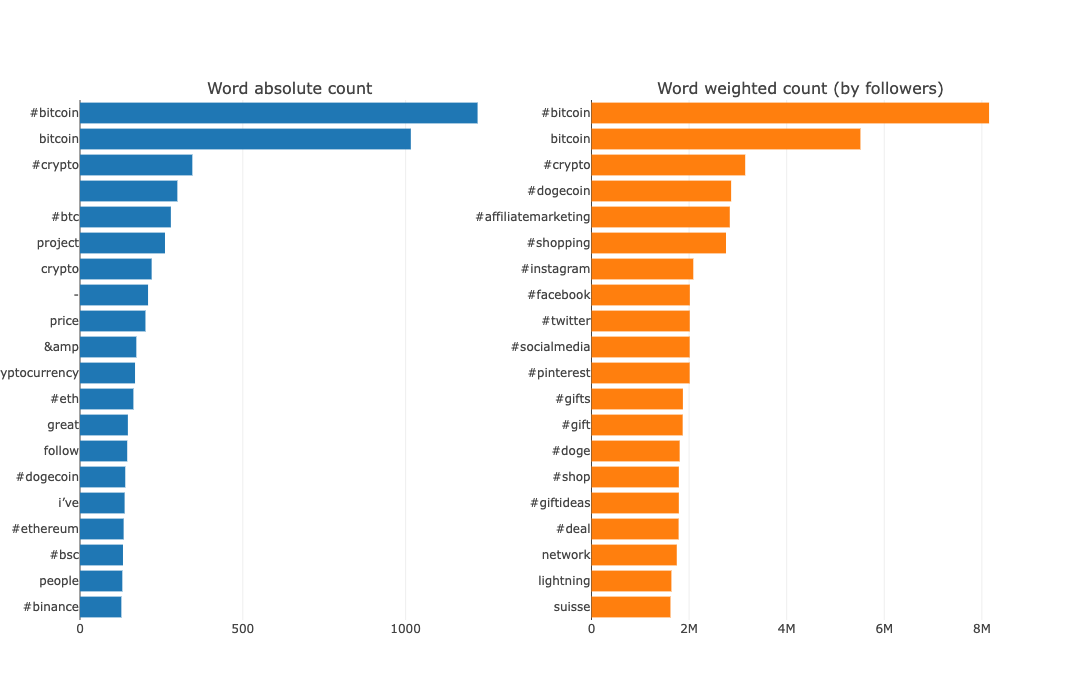

In [12]:
fig = make_subplots(rows=1, cols=2, column_widths=[50, 50],
                    subplot_titles=['Word absolute count', 'Word weighted count (by followers)'])

fig.add_bar(x=word_freq_df.sort_values('abs_freq', ascending=False)['abs_freq'][:20][::-1],
            y=word_freq_df.sort_values('abs_freq', ascending=False)['word'][:20][::-1],
            orientation='h', row=1, col=1, showlegend=False)

fig.add_bar(x=word_freq_df['wtd_freq'][:20][::-1],
            y=word_freq_df['word'][:20][::-1],
            orientation='h', row=1, col=2, showlegend=False)


fig.layout.height = 700
fig.layout.template = 'none'

fig

In [7]:
display.display_markdown("""

# Thank you

""", raw=True)



# Thank you



In [13]:
!jupyter nbconvert 05_interactive_dashboard_tweets.ipynb --to slides --no-input
!open 05_interactive_dashboard_tweets.slides.html

[NbConvertApp] Converting notebook 05_interactive_dashboard_tweets.ipynb to slides
[NbConvertApp] Writing 590118 bytes to 05_interactive_dashboard_tweets.slides.html
